### Objectives

1. Download, merge, and describe the dataset and its basic characteristics (e.g., shape,
variable types, basic stats).
2. Choose several variables and create visualizations to show their distributions. Justify
your variable selection.
3. Clean the dataset to handle any missing data and justify your decisions.
4. For building a model, would you rescale any data in this dataset? How and why or
why not?
5. Build a model to identify risk factors for diabetes. Explain your choice of model and
what it can predict. What metrics would you use to assess performance? For this
dataset, how would you know your model is adequate?
6. Using these data, what are some identifiable risk factors for diabetes? How do you
know? Explain as if you were reporting the results to a non-technical stakeholder.

### Code

In [1110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [1111]:
def get_min_max(df, do_print=True):
    ranges = [
        {"name": col, "min": df[col].min(), "max": df[col].max()} for col in df.columns
    ]

    if do_print:
        print(ranges)

    else:
        return ranges

# 1. 

## 1a. Download

In [1112]:
dc = pd.read_csv("data/data_categorical.csv")
dn = pd.read_csv("data/data_numeric.csv")
do = pd.read_csv("data/data_ordinal.csv")

In [1113]:
#drop duplicate columns
dc.drop(columns=["DIABETE3.1", "MARITAL.1"], inplace=True)

In [1114]:
# dc["HLTHPLN1"].value_counts()

## 1b. Merge

In [1115]:
dc_dn = dc.merge(dn, how="inner")
alldf = dc_dn.merge(do, how="inner")
alldf.set_index("PERSONID", inplace=True)

In [1116]:
# copy of data without Categorical types to use for correlation
alldf_tmp = alldf.copy()

In [1117]:
cat_columns = list(dc.columns[1:])
cat_columns.extend(
    ["GENHLTH", "_AGEG5YR", "_BMI5CAT", "CHECKUP1", "INCOME2", "_EDUCAG", "_SMOKER3"]
)

for c in cat_columns:
    alldf[c] = pd.Categorical(alldf[c])

## 1c. Describe the dataset and its basic characteristics (e.g., shape, variable types, basic stats)

### Original version

In [1118]:
alldf.head()

DIABETE3 _RACE MSCODE FLUSHOT6 EMPLOY1  SEX MARITAL CVDCRHD4  \
PERSONID                                                                
355467        3.0   2.0    NaN      2.0     1.0  1.0     6.0      2.0   
117235        3.0   1.0    5.0      1.0     7.0  2.0     3.0      2.0   
268614        3.0   1.0    1.0      1.0     7.0  2.0     3.0      2.0   
332821        3.0   4.0    NaN      2.0     1.0  1.0     1.0      2.0   
348522        3.0   1.0    NaN      1.0     1.0  2.0     1.0      2.0   

         HLTHCVR1 CHCKIDNY  ... DRVISITS GENHLTH _AGEG5YR _BMI5CAT CHECKUP1  \
PERSONID                    ...                                               
355467        7.0      2.0  ...      6.0     1.0      6.0      3.0      3.0   
117235        2.0      2.0  ...      2.0     1.0     10.0      3.0      1.0   
268614        3.0      2.0  ...      2.0     2.0     12.0      2.0      1.0   
332821        NaN      2.0  ...      NaN     2.0      3.0      2.0      1.0   
348522        1.0      2.0  ...      1.0     2.0      9.0      2.0      2.0   

         INCOME2 _EDUCAG SLEPTIM1 MENTHLTH _SMOKER3  
PERSONID                                             
355467       3.0     3.0      6.0     88.0      4.0  
117235       4.0     2.0      7.0     88.0      4.0  
268614       3.0     2.0      8.0      2.0      4.0  
332821       8.0     4.0      6.0     15.0      3.0  
348522       8.0     3.0      7.0     88.0      4.0  

[5 rows x 33 columns]

In [1119]:
alldf.shape

(5000, 33)

In [1120]:
alldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 355467 to 168122
Data columns (total 33 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   DIABETE3  5000 non-null   category
 1   _RACE     4997 non-null   category
 2   MSCODE    3187 non-null   category
 3   FLUSHOT6  4762 non-null   category
 4   EMPLOY1   4981 non-null   category
 5   SEX       5000 non-null   category
 6   MARITAL   4990 non-null   category
 7   CVDCRHD4  5000 non-null   category
 8   HLTHCVR1  3318 non-null   category
 9   CHCKIDNY  5000 non-null   category
 10  USEEQUIP  4837 non-null   category
 11  _TOTINDA  5000 non-null   category
 12  ADDEPEV2  5000 non-null   category
 13  RENTHOM1  4898 non-null   category
 14  EXERANY2  5000 non-null   category
 15  BLIND     4830 non-null   category
 16  DECIDE    4829 non-null   category
 17  HLTHPLN1  5000 non-null   category
 18  _STATE    5000 non-null   category
 19  ASTHMA3   5000 non-null   category
 20  N

In [1121]:
alldf.describe()

NUMADULT     CHILDREN      WEIGHT2     DRVISITS     SLEPTIM1  \
count  3240.000000  4988.000000  4950.000000  3567.000000  5000.000000   
mean      1.798765    65.691059   588.407071    16.079619     7.942400   
std       0.794935    37.779210  1910.764319    27.913442     8.228574   
min       1.000000     1.000000    75.000000     1.000000     1.000000   
25%       1.000000     4.000000   145.000000     2.000000     6.000000   
50%       2.000000    88.000000   175.000000     4.000000     7.000000   
75%       2.000000    88.000000   205.000000    10.000000     8.000000   
max       7.000000    99.000000  9999.000000    99.000000    99.000000   

          MENTHLTH  
count  5000.000000  
mean     65.437000  
std      35.469943  
min       1.000000  
25%      30.000000  
50%      88.000000  
75%      88.000000  
max      99.000000

### Cleaned version

#### Clean dataset

1. Drop NA/missing/refused/do not know/not sure values

In [1122]:
def drop_missing(df, print_col=None):
    """
    drop BLANK/missing/refused/don't know/not sure values - inferred from the variable dictionary - from each column
    """
    drop_vals = {
        # "PERSONID": [],
        "DIABETE3": [7, 9],
        "_RACE": [9],
        # "MSCODE": [],
        "EMPLOY1": [9],
        # "SEX": [],
        "MARITAL": [9],
        "RENTHOM1": [7, 9],
        # "_STATE": [],
        # "NUMADULT": [],
        "CHILDREN": [99],
        "INCOME2": [77, 99],
        "_EDUCAG": [9],
        "WEIGHT2": [7777, 9999],
        "FLUSHOT6": [7, 9],
        "CVDCRHD4": [7, 9],
        "HLTHCVR1": [77, 99],
        "CHCKIDNY": [7, 9],
        "USEEQUIP": [7, 9],
        "_TOTINDA": [9],
        "ADDEPEV2": [7, 9],
        "EXERANY2": [7, 9],
        "BLIND": [7, 9],
        "DECIDE": [7, 9],
        "HLTHPLN1": [7, 9],
        "ASTHMA3": [7, 9],
        "DRVISITS": [77],
        "GENHLTH": [7, 9],
        "_AGEG5YR": [14],
        # "_BMI5CAT": [],
        "CHECKUP1": [7, 9],
        "SLEPTIM1": [77, 99],
        "MENTHLTH": [77, 99],
        "_SMOKER3": [9],
    }

    for col, v in drop_vals.items():
        df = df[~df[col].isin(v)]
        if print_col:
            print(
                f"\n\ncol = {col}-------\ndf[{print_col}].value_counts():\n{df[print_col].value_counts()}"
            )

    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

**NOTE:** HLTHPLN1 becomes NaN in corr() because I'm dropping rows with "missing"/"refused"/"do not know" values. Perhaps there's a better way to address these types of values than just deleting the full row?

In [1123]:
alldf_tmp = drop_missing(alldf_tmp, print_col="HLTHPLN1")



col = DIABETE3-------
df[HLTHPLN1].value_counts():
1.0    4615
2.0     358
9.0      12
7.0       8
Name: HLTHPLN1, dtype: int64


col = _RACE-------
df[HLTHPLN1].value_counts():
1.0    4528
2.0     353
9.0      11
7.0       8
Name: HLTHPLN1, dtype: int64


col = EMPLOY1-------
df[HLTHPLN1].value_counts():
1.0    4514
2.0     348
9.0       9
7.0       8
Name: HLTHPLN1, dtype: int64


col = MARITAL-------
df[HLTHPLN1].value_counts():
1.0    4498
2.0     345
9.0       9
7.0       7
Name: HLTHPLN1, dtype: int64


col = RENTHOM1-------
df[HLTHPLN1].value_counts():
1.0    4467
2.0     342
9.0       9
7.0       6
Name: HLTHPLN1, dtype: int64


col = CHILDREN-------
df[HLTHPLN1].value_counts():
1.0    4458
2.0     341
9.0       8
7.0       6
Name: HLTHPLN1, dtype: int64


col = INCOME2-------
df[HLTHPLN1].value_counts():
1.0    3858
2.0     303
9.0       5
7.0       3
Name: HLTHPLN1, dtype: int64


col = _EDUCAG-------
df[HLTHPLN1].value_counts():
1.0    3837
2.0     298
9.0       5
7.0     

2. Make WEIGHT2 as one metric
   1. Arbitrarily chose pounds
   2. 1 kg = 2.2 lbs
   3. 9000 - 9998 is kg without first 9. Ex: 9139 = 139kg

In [1124]:
alldf_tmp.loc[alldf_tmp["WEIGHT2"] > 999, "WEIGHT2"] -= 9000 #get kg
alldf_tmp.loc[alldf_tmp["WEIGHT2"] > 999, "WEIGHT2"] /= 2.2 #kg -> lbs

1. Reduce DIABETE3 to 0 = negative diagnosis 1 = positive diagnosis as nuances don't matter, only whether someone has a positive/negative diagnosis
   1. 1 and 2 = Yes, 3 and 4 = No

In [1125]:
alldf_tmp["DIABETE3"] = np.where(alldf_tmp["DIABETE3"] < 3, 1, 0)

4. Turn MENTHLTH, DRVISITS, CHILDREN value 88 to 0
   1. 88 means "None" for these columns

In [1126]:
for col in ["MENTHLTH", "DRVISITS", "CHILDREN"]:
    alldf_tmp[col].replace({88: 0}, inplace=True)

In [1127]:
alldf_tmp["HLTHPLN1"].value_counts()

1.0    1564
Name: HLTHPLN1, dtype: int64

### new dataset shape, variable types, and basic stats

In [1128]:
alldf_new = alldf_tmp.copy()

for c in cat_columns:
    alldf_new[c] = pd.Categorical(alldf_new[c])

In [1129]:
alldf_new.shape

(1564, 33)

In [1130]:
alldf_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564 entries, 0 to 1563
Data columns (total 33 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   DIABETE3  1564 non-null   category
 1   _RACE     1564 non-null   category
 2   MSCODE    1564 non-null   category
 3   FLUSHOT6  1564 non-null   category
 4   EMPLOY1   1564 non-null   category
 5   SEX       1564 non-null   category
 6   MARITAL   1564 non-null   category
 7   CVDCRHD4  1564 non-null   category
 8   HLTHCVR1  1564 non-null   category
 9   CHCKIDNY  1564 non-null   category
 10  USEEQUIP  1564 non-null   category
 11  _TOTINDA  1564 non-null   category
 12  ADDEPEV2  1564 non-null   category
 13  RENTHOM1  1564 non-null   category
 14  EXERANY2  1564 non-null   category
 15  BLIND     1564 non-null   category
 16  DECIDE    1564 non-null   category
 17  HLTHPLN1  1564 non-null   category
 18  _STATE    1564 non-null   category
 19  ASTHMA3   1564 non-null   category
 20  NUMADULT

In [1131]:
alldf_new.describe()

NUMADULT     CHILDREN      WEIGHT2     DRVISITS     SLEPTIM1  \
count  1564.000000  1564.000000  1564.000000  1564.000000  1564.000000   
mean      1.809463     0.455243   175.544118     5.744246     7.096547   
std       0.766050     0.989344    42.326383     8.724609     1.350439   
min       1.000000     0.000000    84.000000     0.000000     1.000000   
25%       1.000000     0.000000   145.000000     2.000000     6.000000   
50%       2.000000     0.000000   170.000000     3.000000     7.000000   
75%       2.000000     0.000000   200.000000     6.000000     8.000000   
max       6.000000     7.000000   400.000000    99.000000    18.000000   

          MENTHLTH  
count  1564.000000  
mean      2.978261  
std       7.087754  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       2.000000  
max      30.000000

# 2.

## Basic Distribution Visualizations

### 2a. Choose several variables

In [1132]:
variables = alldf_new.columns

### 2b Create visualizations to show their distributions.

Text(0.5, 1.0, 'Diabetes Distribution')

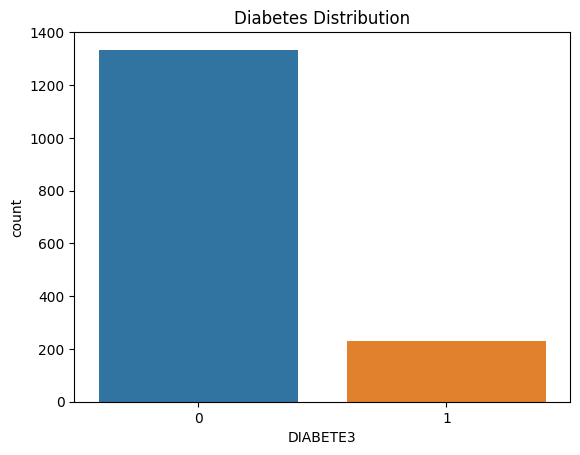

In [1133]:
# make target variable distribution

sns.countplot(x="DIABETE3", data=alldf_new)
plt.title("Diabetes Distribution")

# it's an imbalanced distribution

In [1134]:
custom_plots = {
    "_RACE": {
        "labels": {
            1: "White",
            2: "Black",
            3: "Am. Indian",
            4: "Asian",
            5: "Pacific",
            6: "Other",
            7: "Multiracial",
            8: "Hispanic",
            9: "Not Sure",
        },
        "figsize": None,
    },
    "SEX": {"labels": {1: "Male", 2: "Female"}, "figsize": None},
    "_STATE": {"labels": None, "figsize": (12, 5)},
    "DRVISITS": {"labels": None, "figsize": (12, 5)},
}

In [1135]:
def graph(variable, df=alldf_new, figsize=None, labels=None):
    var_df = df.copy()

    if labels:
        var_df[variable] = df[variable].replace(labels)

    var_df.groupby(variable)["DIABETE3"].value_counts(normalize=True).unstack().plot(
        kind="bar", figsize=figsize, title=f"Diabetes Distribution over {variable}"
    )

/home/emily/miniconda3/envs/env_py38/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


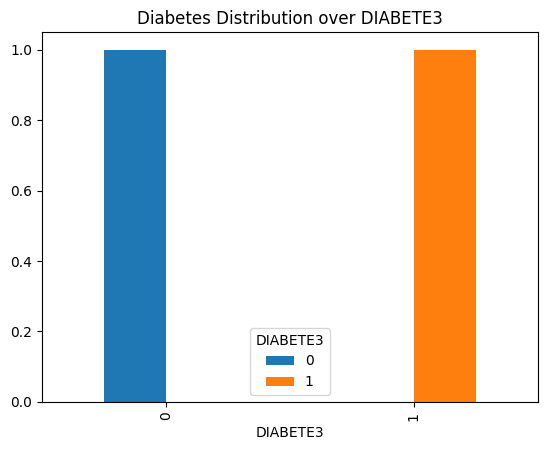

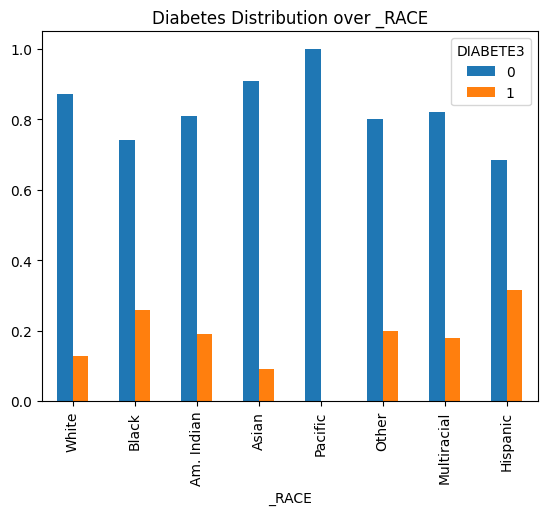

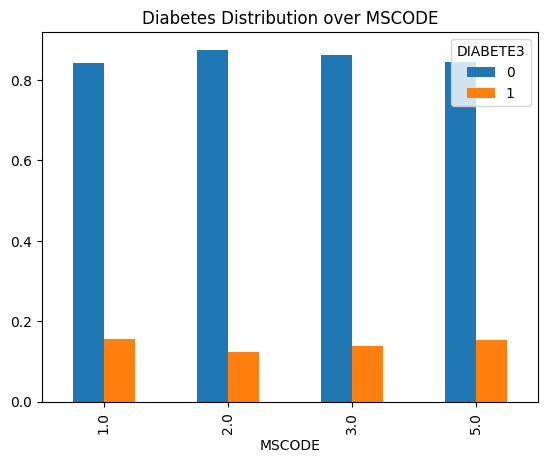

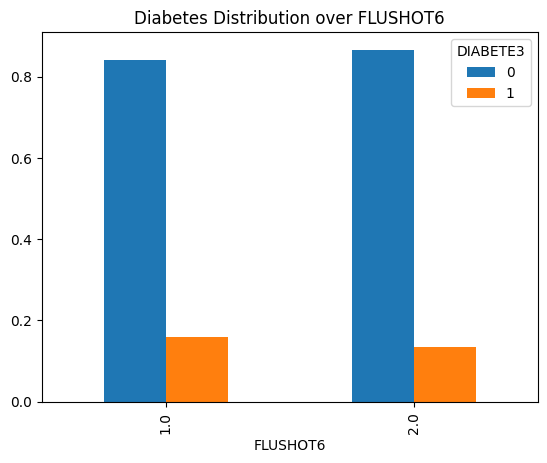

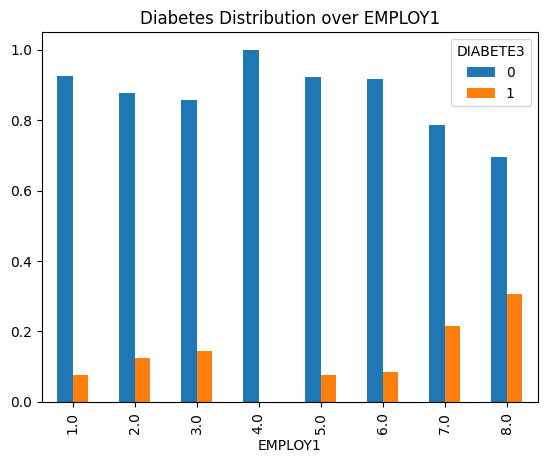

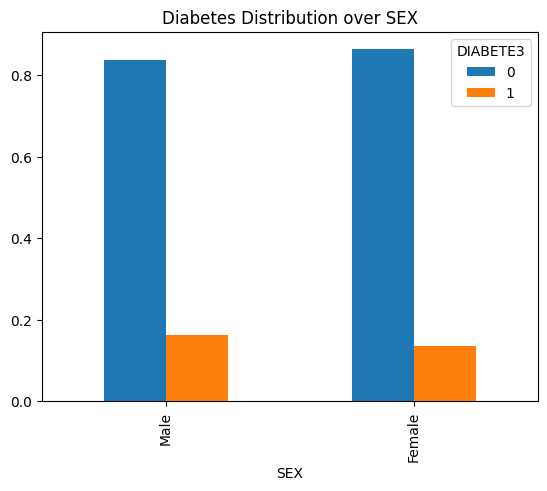

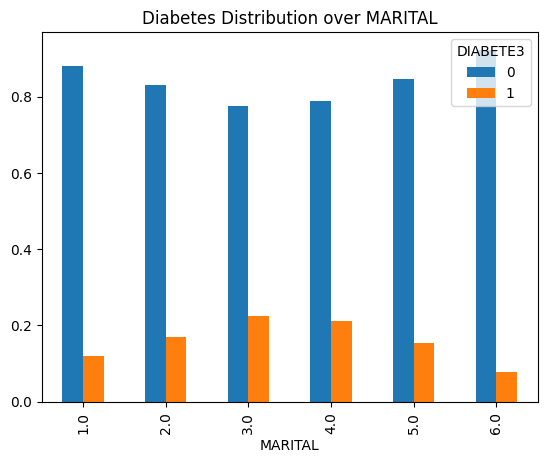

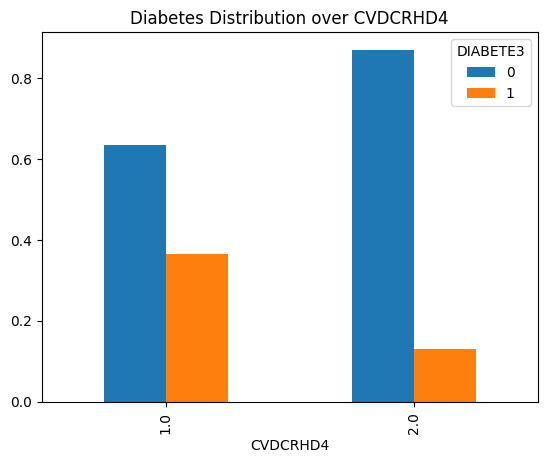

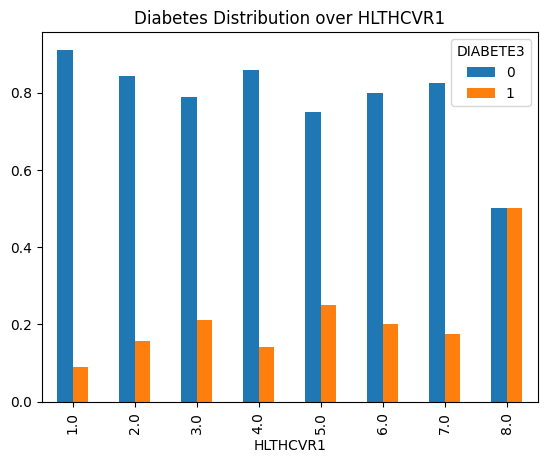

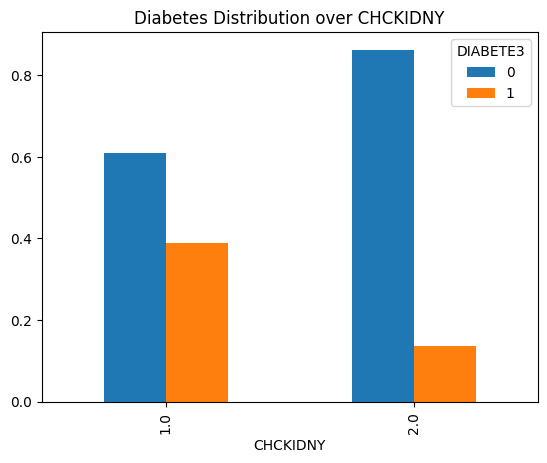

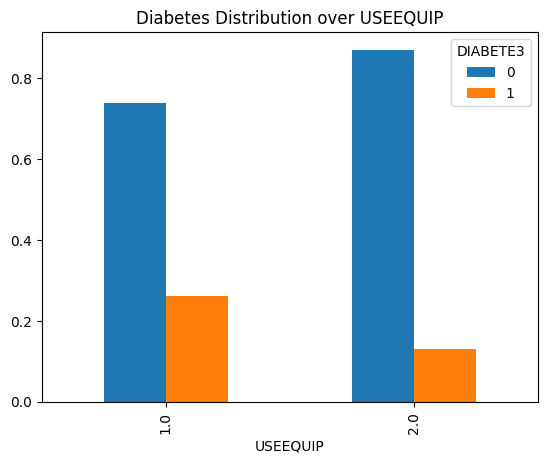

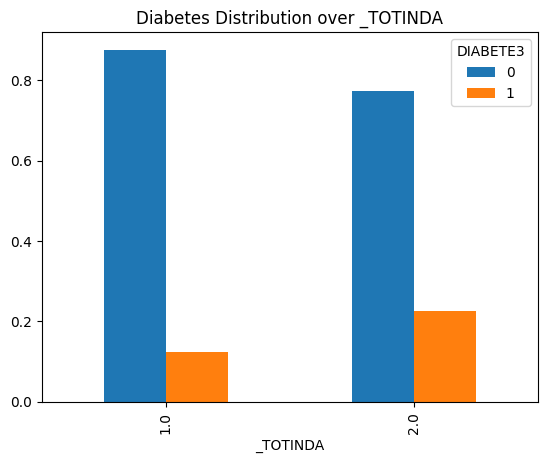

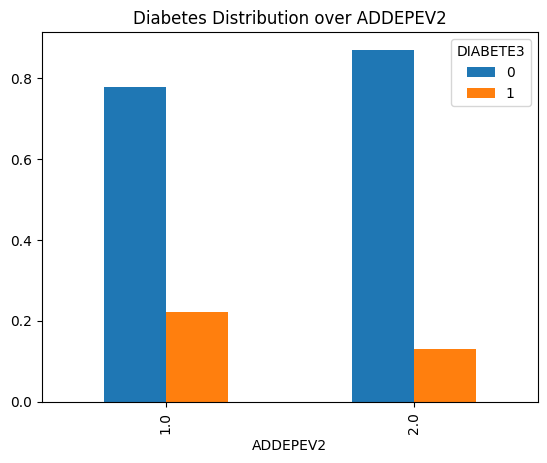

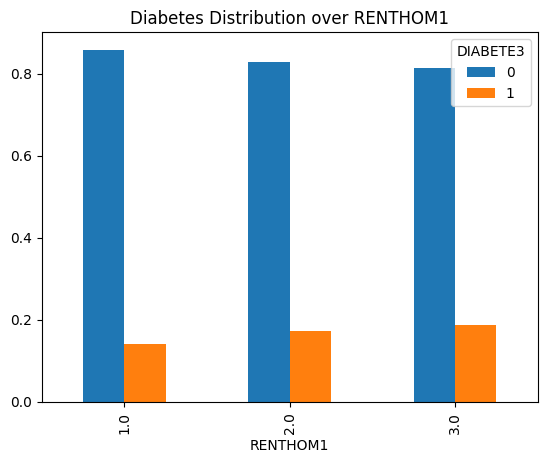

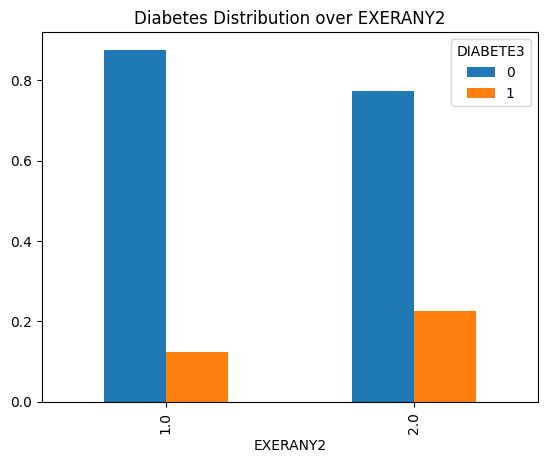

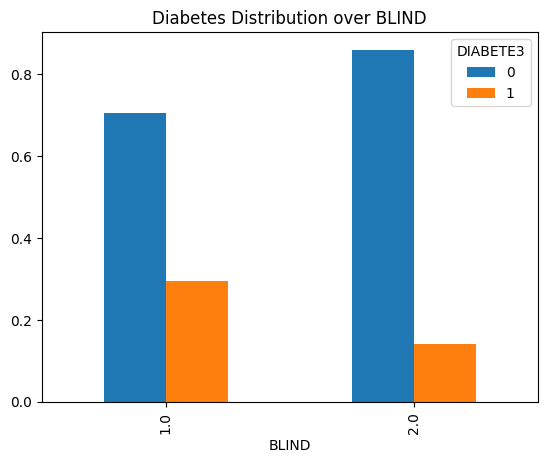

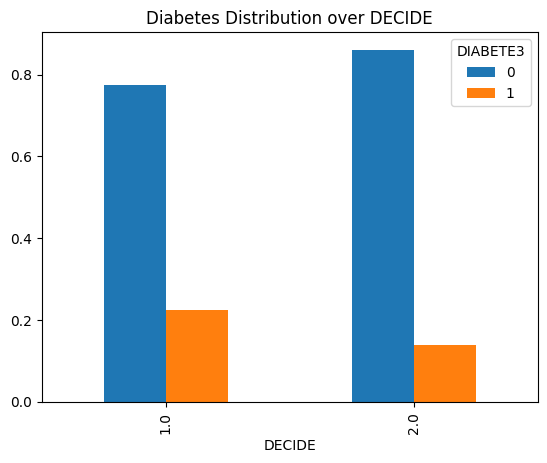

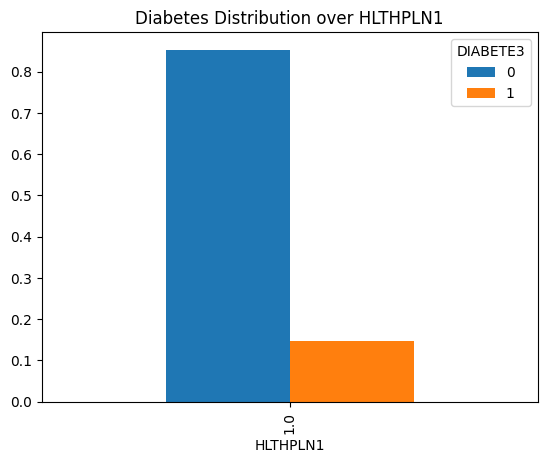

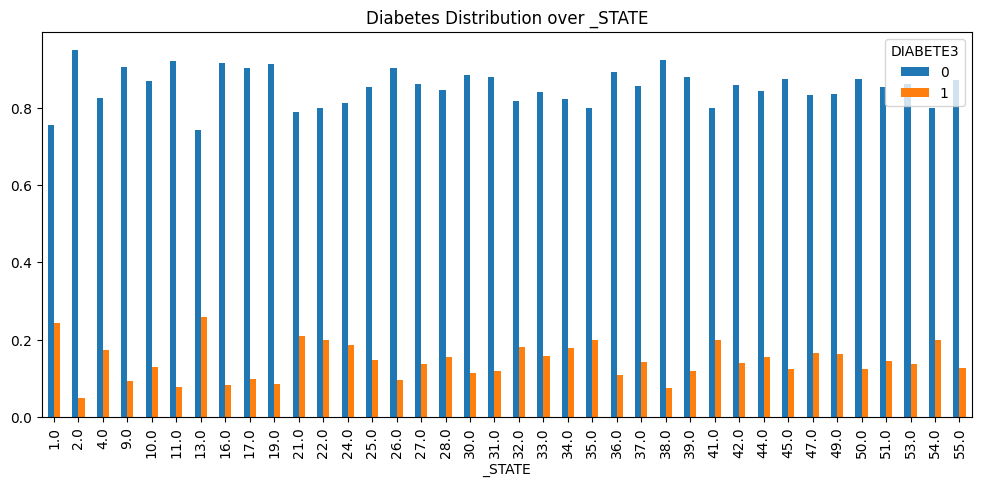

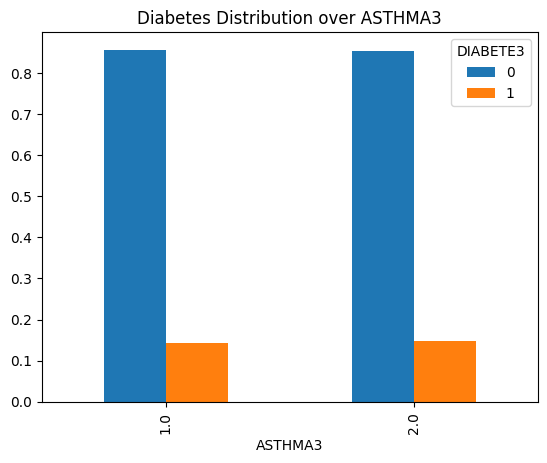

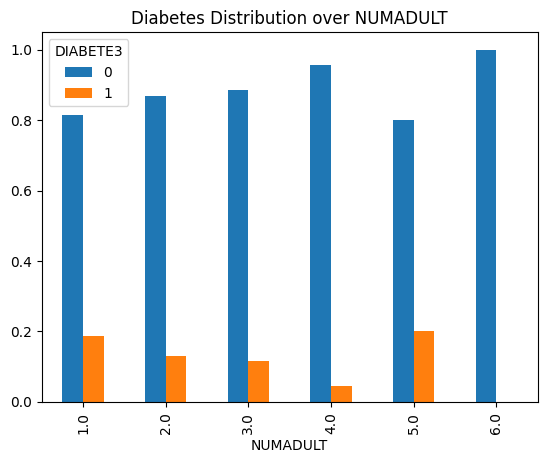

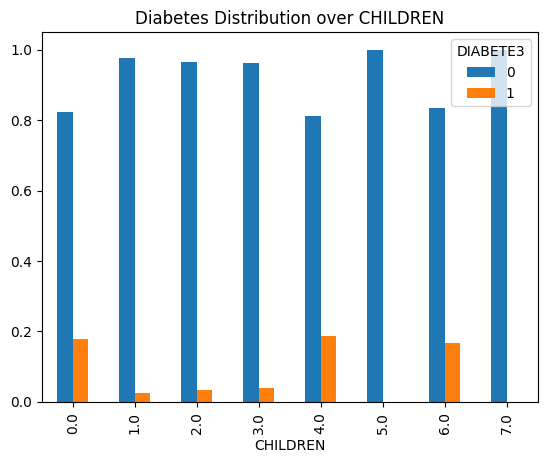

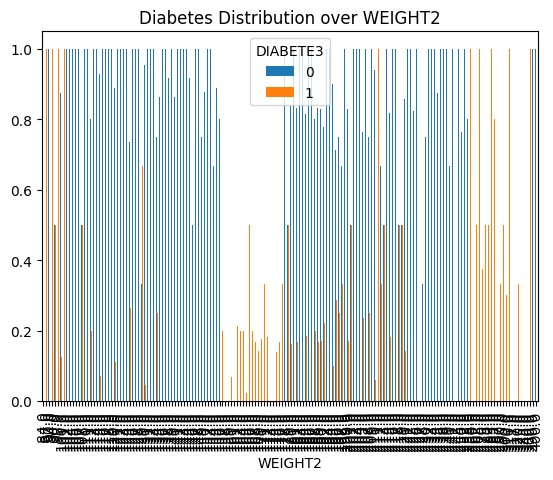

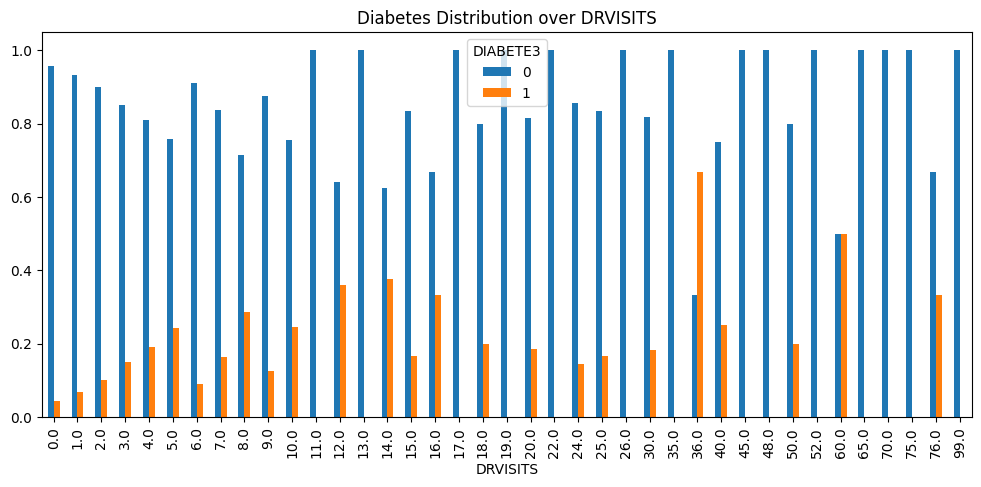

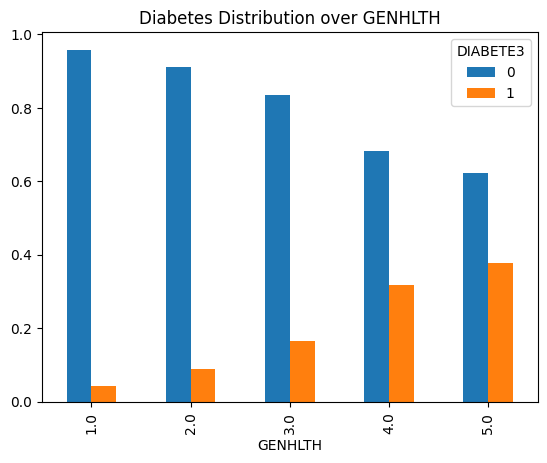

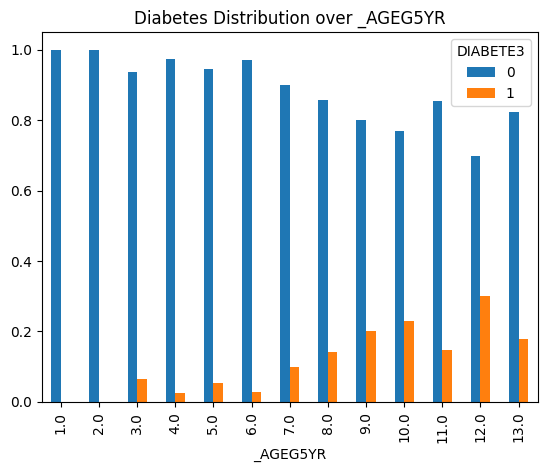

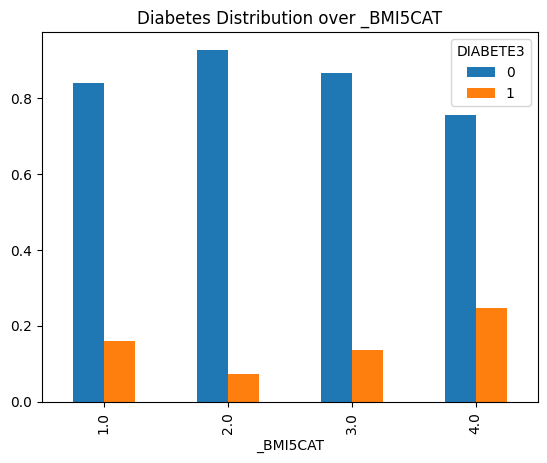

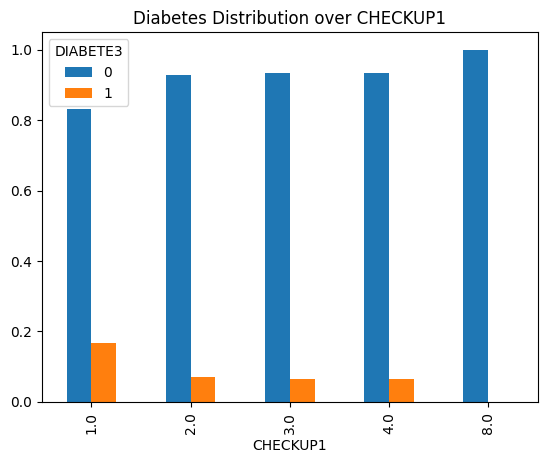

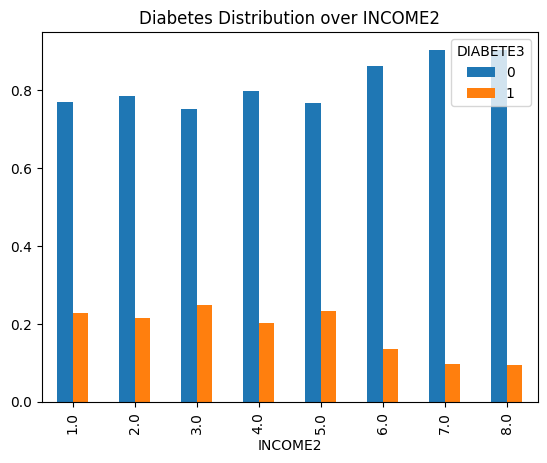

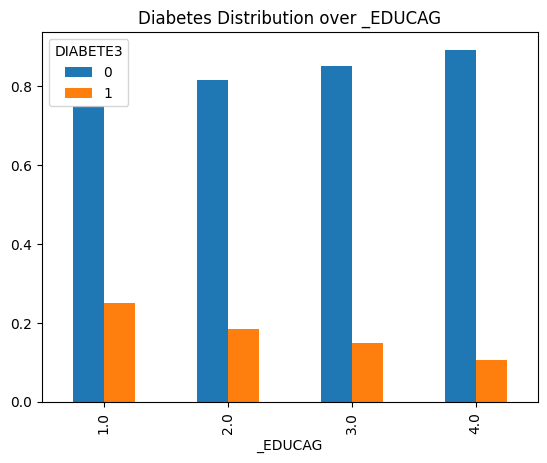

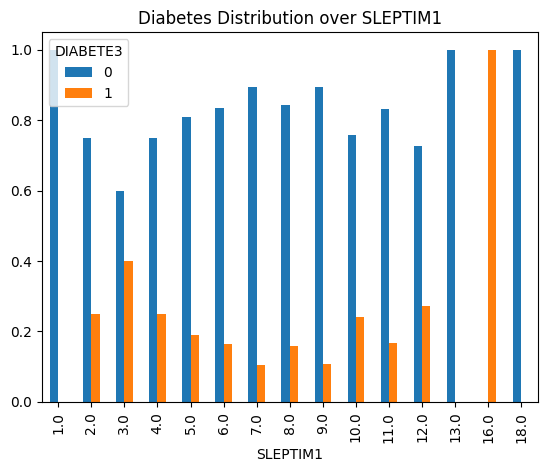

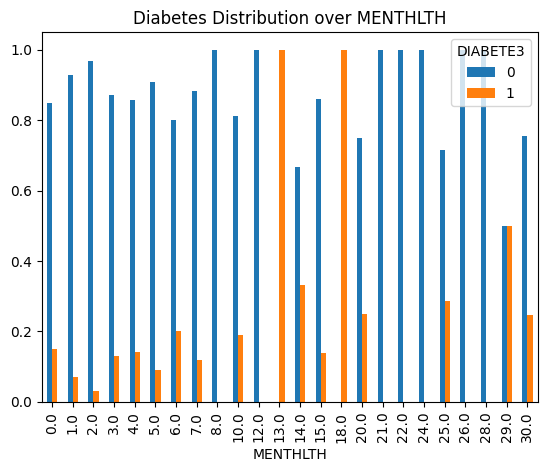

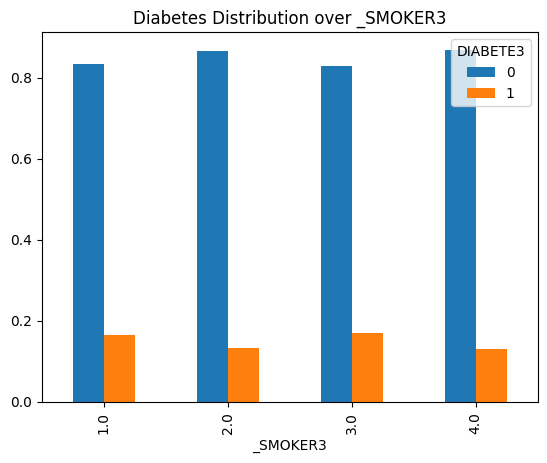

In [1136]:
for v in variables:
    if v in custom_plots:
        graph(
            v,
            figsize=custom_plots[v].get("figsize"),
            labels=custom_plots[v].get("labels"),
        )
    else:
        graph(v)

## 2c. Justify your variable selection

Don't necessarily know how to do this part yet at this point. I just chose all the variables. Is there another way I should answer this question and choose my variables?

## Population Analysis

#### Notes

**Correlation:**

- If a correlation value is negative or very low, it indicates a weak relationship with DIABETE3. For example, _RACE has a negative value, suggesting a weak relationship, so consider dropping _RACE as a variable. However, later on, it's observed that all independent variables have a weak relationship to the target, so it's wiser to instead observe relationships to DIABETE3 with combined features.

- A negative relationship implies an inverse correlation, while a positive relationship means that as one variable increases, the other also increases. If there's no relationship, there isn't a set rule for what happens to the other variable.

- The range of the correlation coefficient (\(r\)) is -1 to 1, where:
  - \(r = 1\): Perfect positive relationship
  - \(0.5 < r < 1\): Strong positive relationship
  - \(0 < r \leq 0.5\): Weak positive relationship
  - \(-0.5 \leq r < 0\): Weak negative relationship
  - \(-1 < r < -0.5\): Strong negative relationship
  - \(r = -1\): Perfect negative relationship
  - \(r = 0\): No relationship

- A variable can **only** have a perfect relationship to another variable if compared to itself.

- When using `corr()`, all variables need to be the same length. It cannot work on categorical and numeric types simultaneously. Therefore, run `corr()` when all features are of the same type.

*Refer to the correlation formula for a detailed understanding.*

**Population Analysis:**

- The dataset has a relatively small number of variables compared to the number of entries.

- Overfitting occurs when there are few variables and many entries, leading the model to capture noise instead of true patterns. Underfitting is the opposite, where the model is too simple to capture the underlying patterns.

- Conduct population analysis to identify variables with weak relationships to the target variable (DIABETE3). In a large dataset, it's acceptable to drop these variables to reduce bias and improve model performance.

- Building the model with only the most significant variables helps prevent overfitting and enhances the model's generalizability.


#### Correlation Diagrams

In [1137]:
corr = alldf_tmp.corr()
corr

DIABETE3     _RACE    MSCODE  FLUSHOT6   EMPLOY1       SEX  \
DIABETE3  1.000000  0.097150  0.003845 -0.036764  0.193895 -0.036991   
_RACE     0.097150  1.000000 -0.066072  0.028426 -0.032702  0.008457   
MSCODE    0.003845 -0.066072  1.000000  0.059845  0.002308  0.052018   
FLUSHOT6 -0.036764  0.028426  0.059845  1.000000 -0.110223 -0.026673   
EMPLOY1   0.193895 -0.032702  0.002308 -0.110223  1.000000  0.029350   
SEX      -0.036991  0.008457  0.052018 -0.026673  0.029350  1.000000   
MARITAL   0.051093  0.087641 -0.062539 -0.008231  0.053714  0.072785   
CVDCRHD4 -0.171747  0.014173  0.008319  0.050308 -0.109874  0.051694   
HLTHCVR1  0.134612  0.044427  0.021999 -0.037252  0.426950  0.003014   
CHCKIDNY -0.135722 -0.030087 -0.013219  0.037064 -0.140845  0.006278   
USEEQUIP -0.124341 -0.053342  0.024946  0.049969 -0.260655 -0.005593   
_TOTINDA  0.120544  0.005923  0.051657  0.008821  0.190462  0.089294   
ADDEPEV2 -0.099446  0.017365  0.000498  0.017520 -0.142160 -0.119388   
RENTHOM1  0.034651  0.108182 -0.016214  0.046058  0.087707  0.074220   
EXERANY2  0.120544  0.005923  0.051657  0.008821  0.190462  0.089294   
BLIND    -0.088527 -0.043008 -0.033284 -0.013367 -0.127879 -0.016759   
DECIDE   -0.070418 -0.049467 -0.003792  0.022170 -0.191130 -0.042748   
HLTHPLN1       NaN       NaN       NaN       NaN       NaN       NaN   
_STATE   -0.010397 -0.036751  0.111144 -0.006223 -0.029285  0.072962   
ASTHMA3   0.003697 -0.004805  0.030044  0.035858 -0.021907 -0.072590   
NUMADULT -0.080569  0.079333 -0.010142  0.041846 -0.214812 -0.040389   
CHILDREN -0.123588  0.156419 -0.023791  0.094226 -0.240356  0.051143   
WEIGHT2   0.153550  0.045213  0.016651 -0.006028 -0.022921 -0.420252   
DRVISITS  0.086072 -0.007679 -0.076177 -0.097650  0.134546  0.065714   
GENHLTH   0.269274  0.082329  0.038670 -0.030321  0.341489 -0.015212   
_AGEG5YR  0.184798 -0.148439  0.019331 -0.177782  0.555511 -0.043839   
_BMI5CAT  0.181091  0.050719  0.036210 -0.039336  0.033580 -0.099855   
CHECKUP1 -0.100508 -0.029451  0.047681  0.143016 -0.073803 -0.018455   
INCOME2  -0.151286 -0.116918 -0.113379 -0.027465 -0.401616 -0.125261   
_EDUCAG  -0.113286 -0.055853 -0.134988 -0.048964 -0.215385 -0.037023   
SLEPTIM1 -0.012311 -0.056907 -0.004987 -0.041692  0.089097 -0.014472   
MENTHLTH  0.067011  0.072087 -0.009362  0.011274  0.085227  0.089620   
_SMOKER3 -0.035414  0.010468 -0.028978 -0.071855 -0.090590  0.073199   

           MARITAL  CVDCRHD4  HLTHCVR1  CHCKIDNY  ...  DRVISITS   GENHLTH  \
DIABETE3  0.051093 -0.171747  0.134612 -0.135722  ...  0.086072  0.269274   
_RACE     0.087641  0.014173  0.044427 -0.030087  ... -0.007679  0.082329   
MSCODE   -0.062539  0.008319  0.021999 -0.013219  ... -0.076177  0.038670   
FLUSHOT6 -0.008231  0.050308 -0.037252  0.037064  ... -0.097650 -0.030321   
EMPLOY1   0.053714 -0.109874  0.426950 -0.140845  ...  0.134546  0.341489   
SEX       0.072785  0.051694  0.003014  0.006278  ...  0.065714 -0.015212   
MARITAL   1.000000 -0.030696  0.124449 -0.014897  ...  0.078335  0.100651   
CVDCRHD4 -0.030696  1.000000 -0.086507  0.075162  ... -0.066144 -0.216224   
HLTHCVR1  0.124449 -0.086507  1.000000 -0.076048  ...  0.070893  0.252314   
CHCKIDNY -0.014897  0.075162 -0.076048  1.000000  ... -0.078527 -0.216377   
USEEQUIP -0.109943  0.165742 -0.197480  0.143211  ... -0.186483 -0.374142   
_TOTINDA  0.066527 -0.116441  0.139829 -0.093394  ...  0.081731  0.293957   
ADDEPEV2 -0.072965  0.075018 -0.117963  0.098251  ... -0.187432 -0.270372   
RENTHOM1  0.225145 -0.037716  0.154702 -0.083079  ...  0.058571  0.188604   
EXERANY2  0.066527 -0.116441  0.139829 -0.093394  ...  0.081731  0.293957   
BLIND    -0.040522  0.086704 -0.086949  0.072978  ... -0.098638 -0.162233   
DECIDE   -0.087592  0.088998 -0.166027  0.085728  ... -0.170475 -0.310901   
HLTHPLN1       NaN       NaN       NaN       NaN  ...       NaN       NaN   
_STATE   -0.015292  0.010275 -0.033721  0.031120  ... -0.029028 -0.062012   
ASTHMA3  -0.020447  0

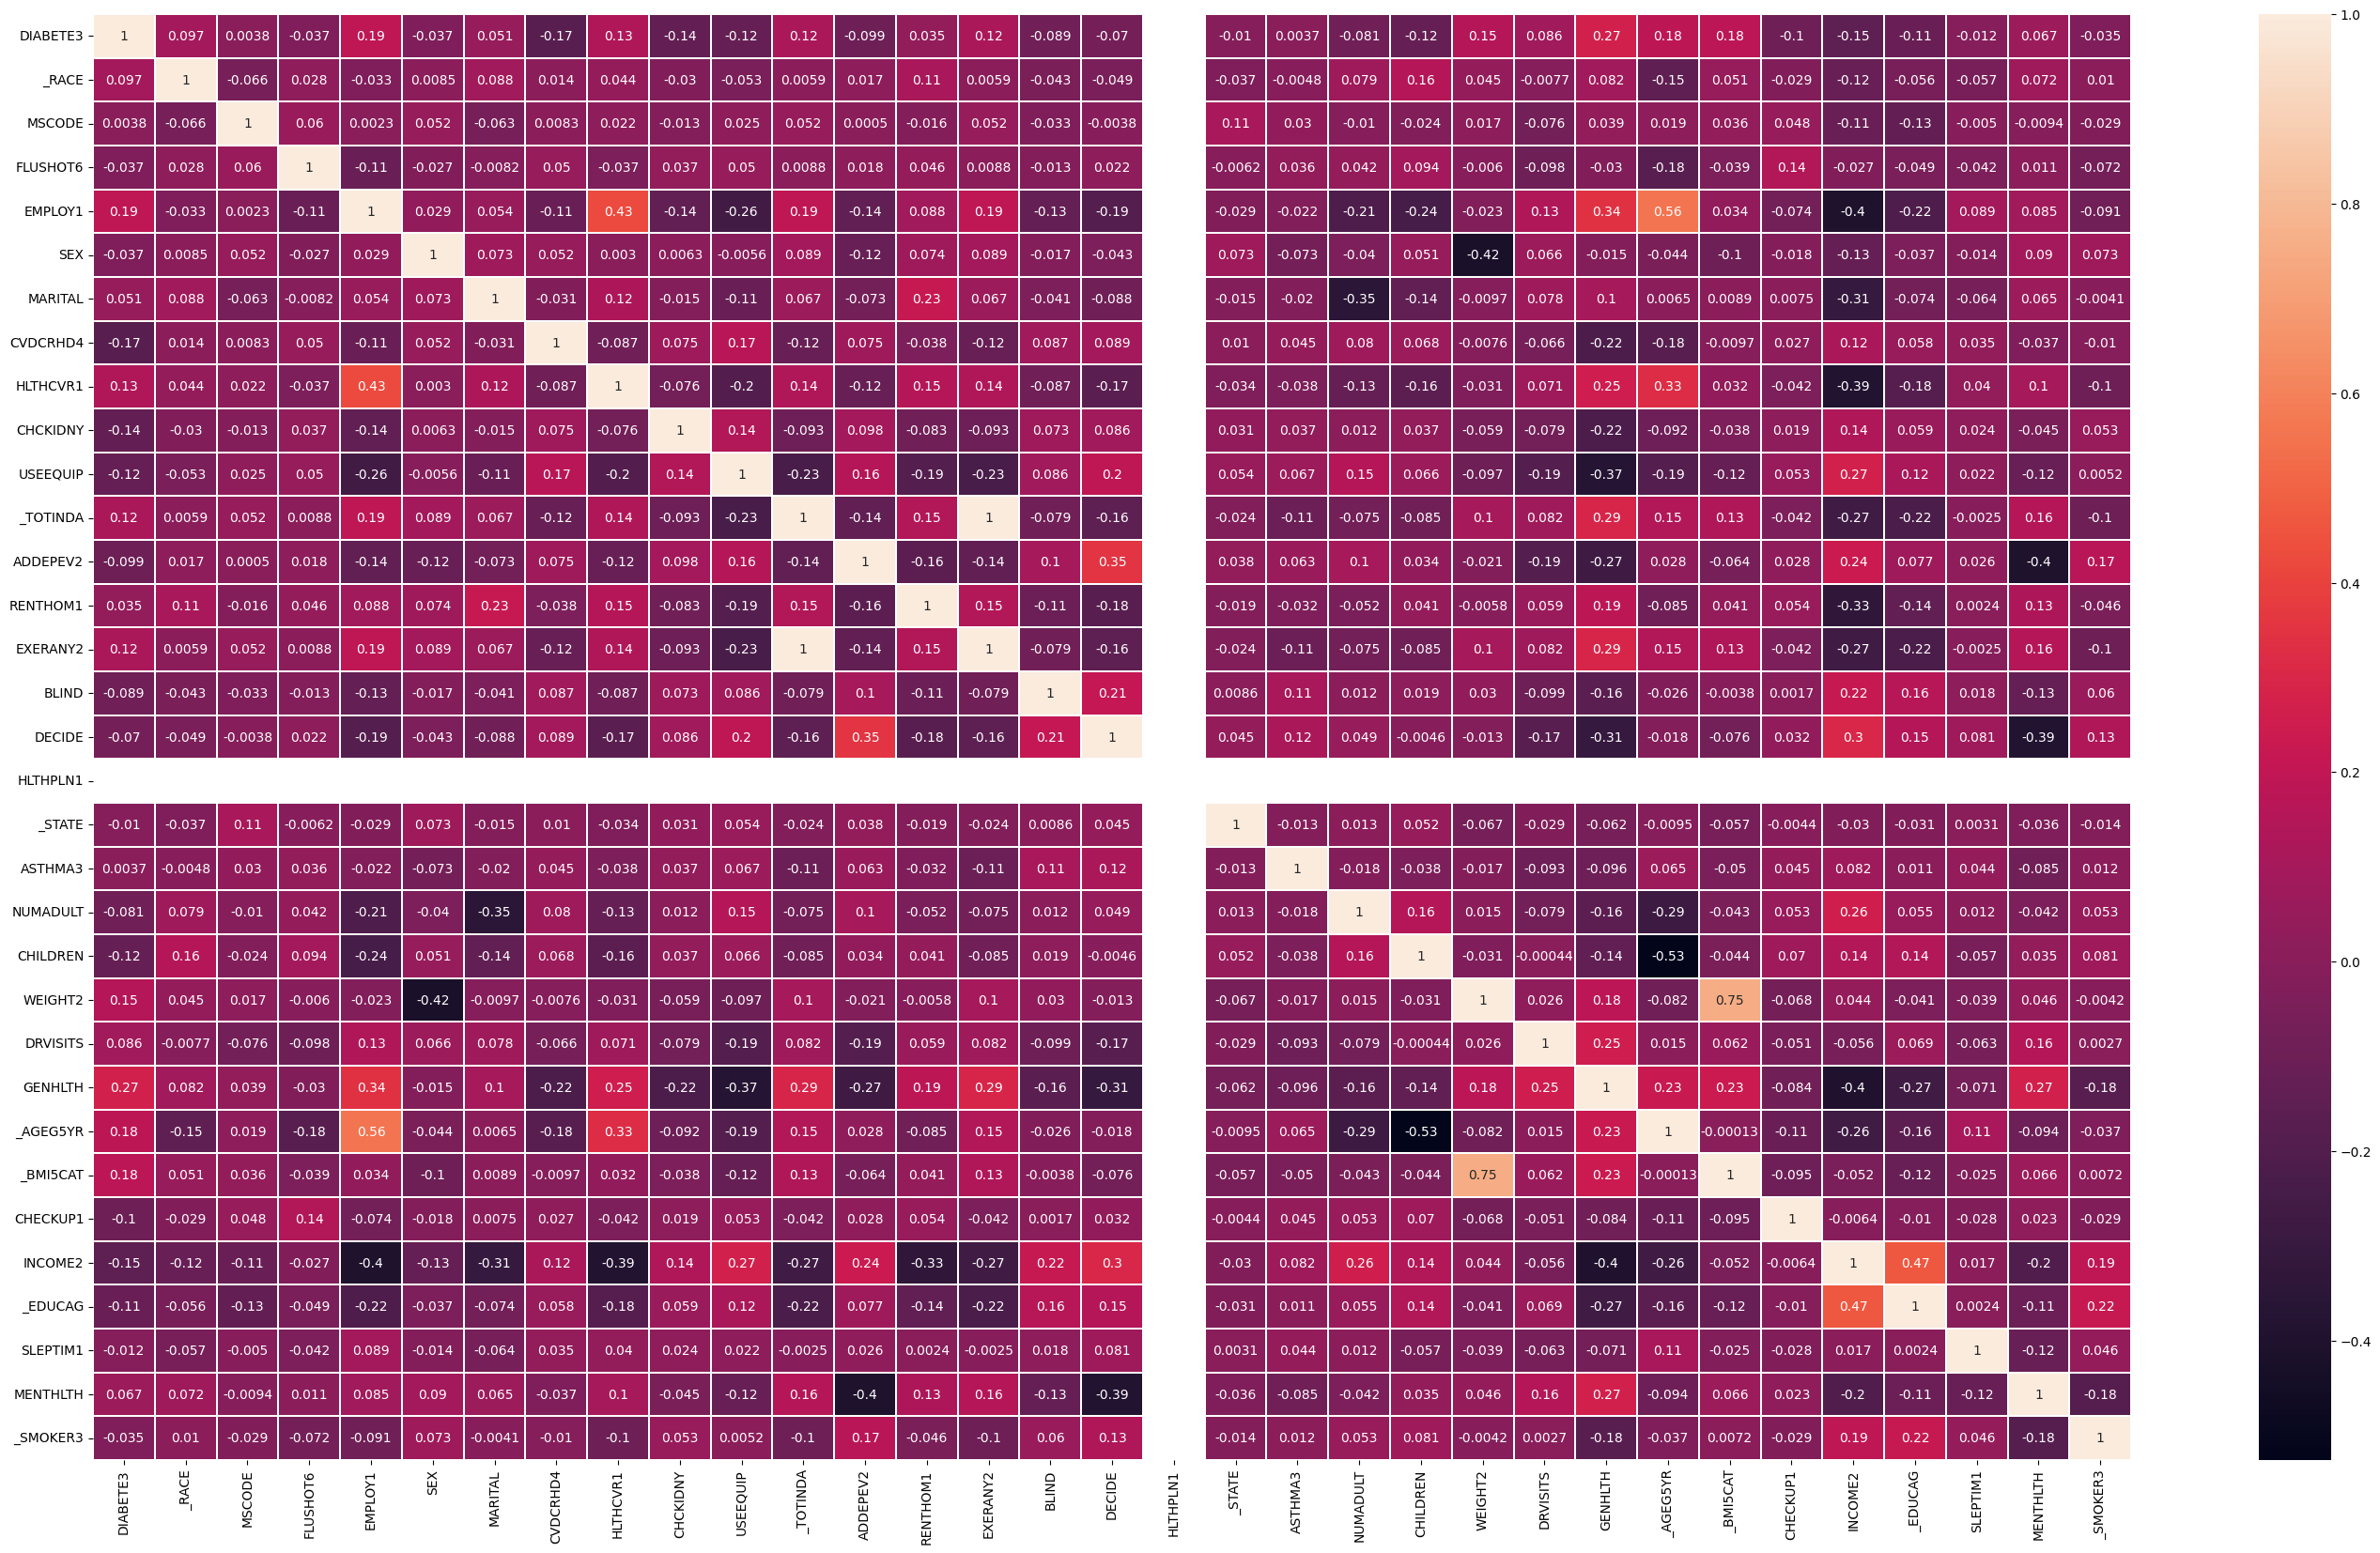

In [1138]:
plt.figure(figsize=(35, 20))

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, linewidths=0.1)
plt.show()

In [1139]:
corr["DIABETE3"]

DIABETE3    1.000000
_RACE       0.097150
MSCODE      0.003845
FLUSHOT6   -0.036764
EMPLOY1     0.193895
SEX        -0.036991
MARITAL     0.051093
CVDCRHD4   -0.171747
HLTHCVR1    0.134612
CHCKIDNY   -0.135722
USEEQUIP   -0.124341
_TOTINDA    0.120544
ADDEPEV2   -0.099446
RENTHOM1    0.034651
EXERANY2    0.120544
BLIND      -0.088527
DECIDE     -0.070418
HLTHPLN1         NaN
_STATE     -0.010397
ASTHMA3     0.003697
NUMADULT   -0.080569
CHILDREN   -0.123588
WEIGHT2     0.153550
DRVISITS    0.086072
GENHLTH     0.269274
_AGEG5YR    0.184798
_BMI5CAT    0.181091
CHECKUP1   -0.100508
INCOME2    -0.151286
_EDUCAG    -0.113286
SLEPTIM1   -0.012311
MENTHLTH    0.067011
_SMOKER3   -0.035414
Name: DIABETE3, dtype: float64

**Observations**

The independent variables exhibit a modest association with diabetes, as indicated by correlation coefficients (r) falling within the range of -.5<=r<0 or 0<r<=0.5. Consequently, it becomes essential to evaluate the collective relationships among the features of the independent variables in connection to diabetes. None of the variables independently can explain the target variable

#### Feature Engineering  
creating new features from highly correlated features

In [1140]:
def get_correlated_features(feature="DIABETE3", corr=corr):
    """
    Given a feature name, get the features with a strong and weak or negligible correlation to it.
    """

    correlation_dict = corr[feature].to_dict()
    weak_dict, strong_dict = {}, {}

    for f, r in correlation_dict.items():
        if -0.5 <= r <= 0.5:
            weak_dict[f] = r
        elif -1 <= r < 1: # no nan or 1 vals
            strong_dict[f] = r

    weak = sorted(weak_dict.items(), key=lambda x: x[1])
    strong = sorted(strong_dict.items(), key=lambda x: x[1], reverse=True)

    return weak, strong

In [1141]:
strong_correlations = []

for col in alldf_new.columns:
    _, strong = get_correlated_features(col)

    strong_correlations.extend([(col, f, v) for f, v in strong])

strong_correlations

[('EMPLOY1', '_AGEG5YR', 0.5555109259599107),
 ('CHILDREN', '_AGEG5YR', -0.5257042148223822),
 ('WEIGHT2', '_BMI5CAT', 0.7507425287733256),
 ('_AGEG5YR', 'EMPLOY1', 0.5555109259599107),
 ('_AGEG5YR', 'CHILDREN', -0.5257042148223822),
 ('_BMI5CAT', 'WEIGHT2', 0.7507425287733256)]

I derived that the strongest correlations are between the following:
- EMPLOY1 and AGEG5YR have a strong positive correlation where r = 0.556
- CHILDREN and _AGEG5YR have a strong negative correlation where r = -0.526.
- WEIGHT2 and _BMI5CAT have a strong positive correlation where r = 0.751. 

**Therefore, these are the variables I choose along with the target variable, DIABETE3.**

sns.countplot is great for plotting two categorical variables. 
- If dodge is set to True, the bars corresponding to different categories of the hue variable will be plotted adjacent to each other. 
- Example: the graph below for age vs employment, the bars for each color within an age group show the count of individuals with that specific employment status in that age group.

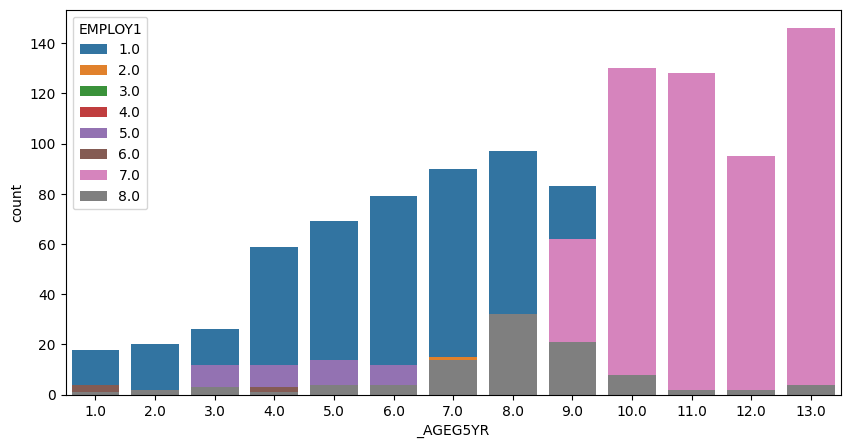

In [1142]:
# 0.555511 (strong positive correlation)

plt.figure(figsize=(10, 5))
sns.countplot(x="_AGEG5YR", hue="EMPLOY1", data=alldf_new, dodge=False)
plt.show()

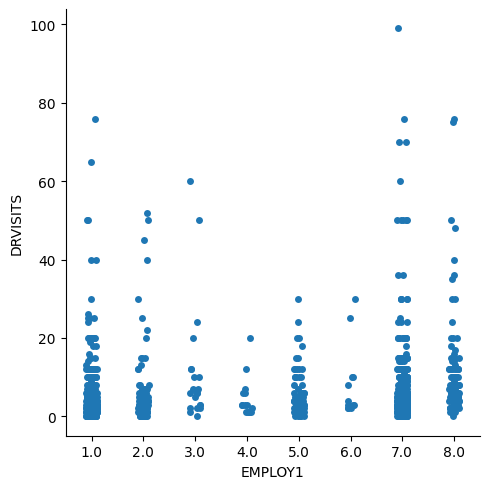

In [1143]:
# -0.053873 (weak negative correlation)
sns.catplot(alldf_new, x="EMPLOY1", y="DRVISITS")

# 3

## 3a. Clean the dataset to handle any missing data

Look at part 1

## 3b. Justify your decisions

I wanted to drop all NA values because those represented BLANK, which corresponds with missing values. Additionally, I decided to get rid of values that correspond to "refused" and "do not know/not sure" because I felt that simplifying the dataset to only include entries where respondents gave clear answers was important for training my model.

# 4

##### 4a. For building a model, would you rescale any data in this dataset? **How** and **why or why not**?

If I were using k-nearest neighbors (knn), gradient descent-based algorithms, principal component analysis, or regularization techniques I would rescale since those models/algorithms are sensitive to feature scales. For instance, distance-based algorithms like knn rely on the distance between data points, so a major difference in scale can lead to greater distances which can dominate distance calculations. So rescaling some features could improve convergence and diminish bias amongst features. The way I would rescale is by standardizing or normalizing the data for features with a major range such as WEIGHT2 since pounds can go from 50-999 and similarly kilograms 9000-9998.

However, I wouldn't need to rescale if I use a tree-based model such as decision trees, random forests, or gradient boosting methods since they're typically insensitive to features' scales. For example, decision trees rely on feature thresholds, which is impartial to the scale of those features.

In my case, I chose to use XGBoosting and also tried regular Gradient Boosting, particularly the classification model version. Therefore, I don't need to rescale as mentioned prior. 

Nonetheless, I will still address the imbalanced nature of my dataset regardless of the model used since I want to mitigate bias to the majority class. I learned by graphing the diabetes distribution there's an overwhelming number of people without diabetes to those with. To resolve this imbalance, I can perform random or synthetic oversampling methods.

Furthermore, for the WEIGHT2 feature, unifying the units to a single metric, such as pounds will help because the model won't recognize the difference between pounds and kilograms. For the target variable DIABETE3, adopting a binary representation where 1 indicates a positive diagnosis of diabetes and 0 signifies the absence of a diabetes diagnosis aligns with my goal of binary classification in the modeling process.

# 5

## 5a Build a model to identify risk factors for diabetes. 

## 5b Explain your choice of model and what it can predict. 

## 5c What metrics would you use to assess performance? 

## 5d For this dataset, how would you know your model is adequate?

In [1144]:
# separate target and independent variables
y = alldf_tmp["DIABETE3"] 
X = alldf_tmp.drop(columns="DIABETE3") 

In [1145]:
# address imbalance in the dataset

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)

X, y = smote.fit_resample(X, y)

In [1146]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

model = XGBClassifier()

# cross validation version
kf = KFold(n_splits=5)
avg_model_scores = np.mean(cross_val_score(model, X, y, cv=kf))
print(avg_model_scores)

0.9071161048689138


In [1147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.88      0.95      0.92       328
           1       0.95      0.88      0.91       339

    accuracy                           0.91       667
   macro avg       0.92      0.92      0.91       667
weighted avg       0.92      0.91      0.91       667



In [1148]:
feature_importances = model.feature_importances_
for feature, importance in sorted(zip(X.columns, feature_importances), key=lambda x: x[1], reverse=True):
  print(f"{feature}: {importance}")

GENHLTH: 0.154740571975708
EMPLOY1: 0.09998351335525513
CVDCRHD4: 0.08383751660585403
USEEQUIP: 0.059891749173402786
FLUSHOT6: 0.05072876065969467
ASTHMA3: 0.04068535193800926
_RACE: 0.04021751880645752
_BMI5CAT: 0.04014509171247482
CHCKIDNY: 0.03483983129262924
_EDUCAG: 0.03292585909366608
DECIDE: 0.02824118174612522
CHILDREN: 0.026723800227046013
MSCODE: 0.024271417409181595
SEX: 0.02417379431426525
DRVISITS: 0.023890823125839233
ADDEPEV2: 0.02349184639751911
_AGEG5YR: 0.02287227287888527
RENTHOM1: 0.021873250603675842
BLIND: 0.020343201234936714
NUMADULT: 0.019765209406614304
CHECKUP1: 0.0188727006316185
MARITAL: 0.017096998170018196
_SMOKER3: 0.014212248846888542
SLEPTIM1: 0.01398951280862093
WEIGHT2: 0.012543221935629845
_TOTINDA: 0.011919441632926464
_STATE: 0.01027120091021061
MENTHLTH: 0.010234910063445568
HLTHCVR1: 0.010118463076651096
INCOME2: 0.007098715286701918
EXERANY2: 0.0
HLTHPLN1: 0.0


# 6. Using these data, what are some identifiable risk factors for diabetes? How do you know? Explain as if you were reporting the results to a non-technical stakeholder.

The most important features are 

GENHLTH: 0.16922499239444733
_TOTINDA: 0.07415896654129028
CHILDREN: 0.07380124181509018
_BMI5CAT: 0.07154451310634613
BLIND: 0.05338083207607269
CVDCRHD4: 0.050223458558321

The least important are:

WEIGHT2: 0.010020529851317406
PERSONID: 0.00973158422857523
MARITAL: 0.009483946487307549
_STATE: 0.008029725402593613
EXERANY2: 0.0
HLTHPLN1: 0.0